# Let’s make a DQN: Debugging

https://gym.openai.com/envs/MountainCar-v0/

Some useful resources:
  * https://jaromiru.com/2016/10/12/lets-make-a-dqn-debugging/

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from keras import models, layers, optimizers
from replay_buffer import ReplayBuffer
from IPython.display import clear_output
%matplotlib inline

# Explore environment

[2018-06-26 14:08:40,635] Making new env: MountainCar-v0


Observation shape: (2,)
Number of actions: 3
Example state: [-0.59494582  0.        ]


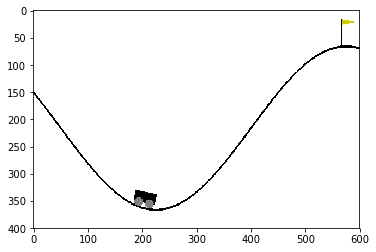

In [5]:
#spawn game instance for tests
env = gym.make("MountainCar-v0") #create raw env

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape: {}".format(observation_shape))
print("Number of actions: {}".format(n_actions))

print("Example state: {}".format(env.reset()))
plt.imshow(env.render('rgb_array'))

# Build DQN Agent

## Define network

In [6]:
class QNetwork:
    
    def __init__(self, input_shape, n_actions, alpha=0.0003):
        self.input_shape = input_shape
        self.output_shape = n_actions
        self.alpha = alpha
        self.model = self._build_network()

    def _build_network(self):
        model = models.Sequential()
        model.add(layers.InputLayer(self.input_shape))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(self.output_shape, activation='linear'))
        opt = optimizers.RMSprop(lr=self.alpha)
        model.compile(loss='mse', optimizer=opt)
        return model
    
    def predict(self, state):
        """Make prediction for single state and return q values for all actions"""
        s = np.expand_dims(state, axis=0)
        return self.model.predict(s)[0]
    
    def predict_batch(self, states):
        """Make prediction for list of states"""
        return self.model.predict(states)
    
    def train(self, x, y):
        self.model.fit(x, y, batch_size=64, verbose=0)

        
network = QNetwork(observation_shape, n_actions)
network.predict(env.reset())

[2018-06-26 15:44:07,024] From /home/klangner/bin/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1349: calling reduce_mean (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


array([ 0.06101993,  0.19870494, -0.00810915], dtype=float32)

## Helper for building training set

In [7]:
def build_training_set(qvalues, qvalues_next, actions, rewards, dones, gamma=0.99):
    """
    Create training set for QNetwork.
    Params:
      qvalues           - Q values for the starting state
      qvalues_next      - Q values for the state the next state
      actions           - Actions taken
      rewards           - Rewards received after taking action 
      dones             - Did this action end the episode?
      
    Returns:
      Expected qvalues
    """
    y = qvalues.copy()
    next_rewards = np.where(dones, np.zeros(rewards.shape), np.max(qvalues_next, axis=1))
    y[np.arange(y.shape[0]), actions] = rewards + gamma * next_rewards
    return y


# Some tests
qvalues = np.zeros((5, n_actions))
qvalues2 = np.ones((5, n_actions))
actions = np.array([0, 1, 0, 1, 0])
rewards = np.array([1, 2, 3, 4, 5])
dones = np.array([False, False, False, False, True])
expected_y = np.array([[2, 0], [0, 3], [4, 0], [0, 5], [5, 0]])
y = build_training_set(qvalues, qvalues2, actions, rewards, dones, 1.0)
assert np.array_equal(y, expected_y), 'Wrong expected qvalue calculated'
print('Ok!')

AssertionError: Wrong expected qvalue calculated